In [1]:
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import json

load_dotenv()

True

In [2]:

db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/postgres"
engine = create_engine(db_url)


sql_query = """
    SELECT olr, shape
    FROM diu.traffic_data GROUP BY olr, shape HAVING COUNT(*) >= 20;
"""
traffic_data = pd.read_sql(sql_query, engine)

In [3]:

def extract_points_from_shape(shape_json):
    points = []
    for segment in shape_json:
        for point in segment['points']:
            points.append((point['lng'], point['lat']))  # Reihenfolge: (lng, lat)
    return points


traffic_data['points'] = traffic_data['shape'].apply(lambda x: extract_points_from_shape(x))


all_points = []
for points in traffic_data['points']:
    all_points.extend(points)


points_df = pd.DataFrame(all_points, columns=['longitude', 'latitude'])

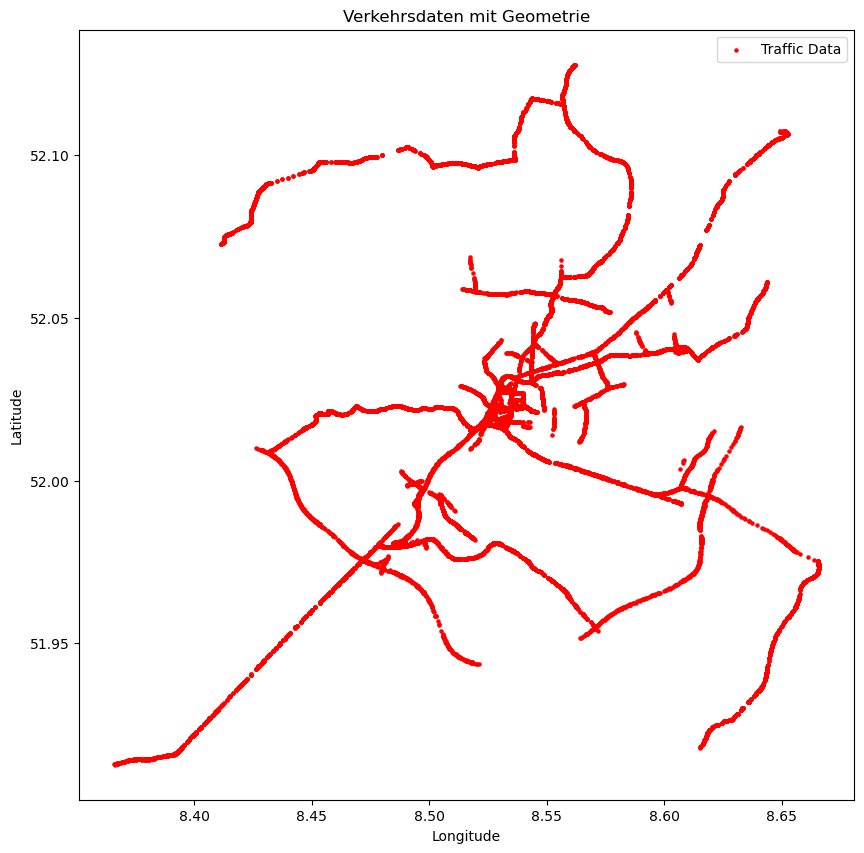

In [4]:

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(points_df['longitude'], points_df['latitude'], color='red', s=5, label='Traffic Data')
plt.title('Verkehrsdaten mit Geometrie')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [5]:

def extract_points_and_centroid_from_shape(shape_json):
    points = []
    lat_sum = 0
    lng_sum = 0
    num_points = 0


    for segment in shape_json:
        for point in segment['points']:
            lng, lat = point['lng'], point['lat']
            points.append((lng, lat))
            lat_sum += lat
            lng_sum += lng
            num_points += 1


    if num_points > 0:
        centroid_lat = lat_sum / num_points
        centroid_lng = lng_sum / num_points
    else:
        centroid_lat, centroid_lng = None, None

    return centroid_lng, centroid_lat


traffic_data['centroid'] = traffic_data['shape'].apply(lambda x: extract_points_and_centroid_from_shape(x))


centroids_df = pd.DataFrame(traffic_data['centroid'].tolist(), columns=['centroid_longitude', 'centroid_latitude'])
centroids_df['olr'] = traffic_data['olr']

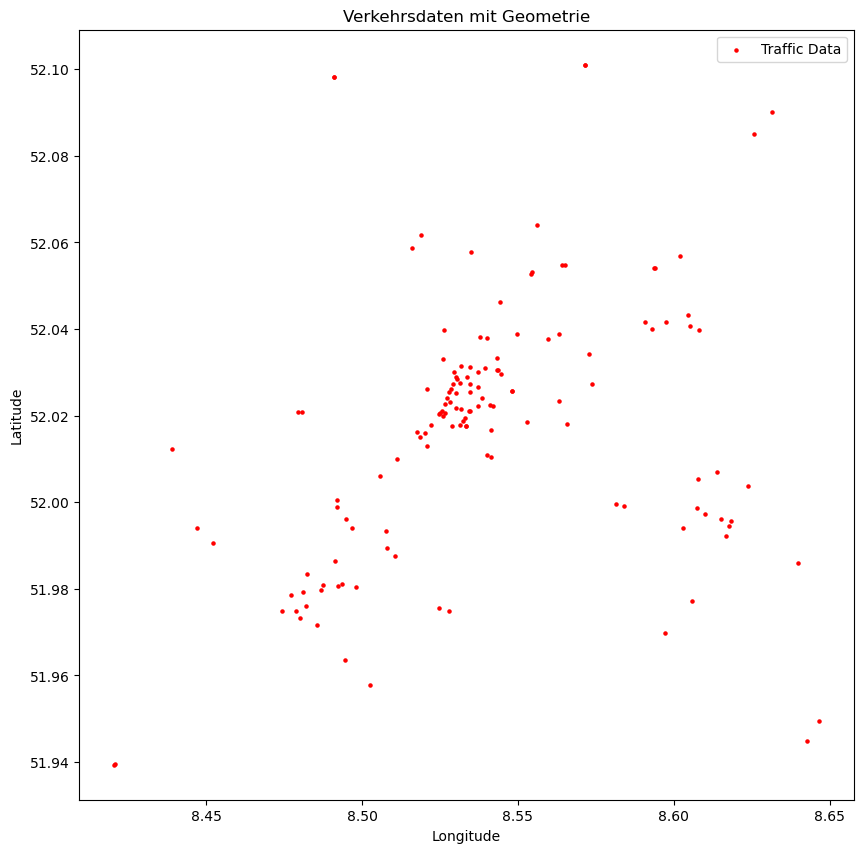

In [6]:

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(centroids_df['centroid_longitude'], centroids_df['centroid_latitude'], color='red', s=5, label='Traffic Data')
plt.title('Verkehrsdaten mit Geometrie')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

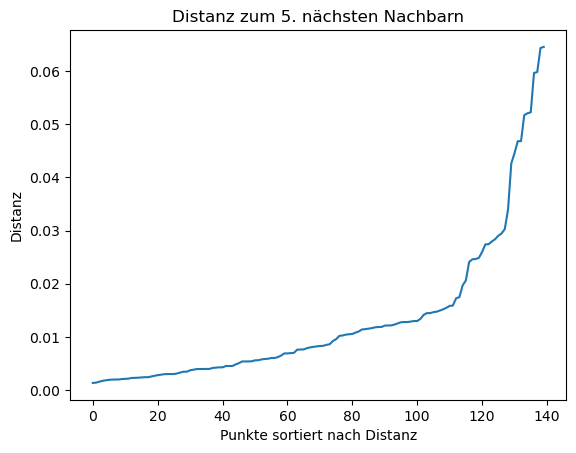

In [7]:

coords_array = centroids_df[['centroid_longitude', 'centroid_latitude']].values


neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(coords_array)
distances, indices = neigh.kneighbors(coords_array)


distance_5th_neighbor = distances[:, -1]


plt.plot(np.sort(distance_5th_neighbor))
plt.title('Distanz zum 5. nächsten Nachbarn')
plt.xlabel('Punkte sortiert nach Distanz')
plt.ylabel('Distanz')
plt.show()

In [8]:

db = DBSCAN(eps=0.013, min_samples=5).fit(coords_array)


centroids_df['cluster'] = db.labels_

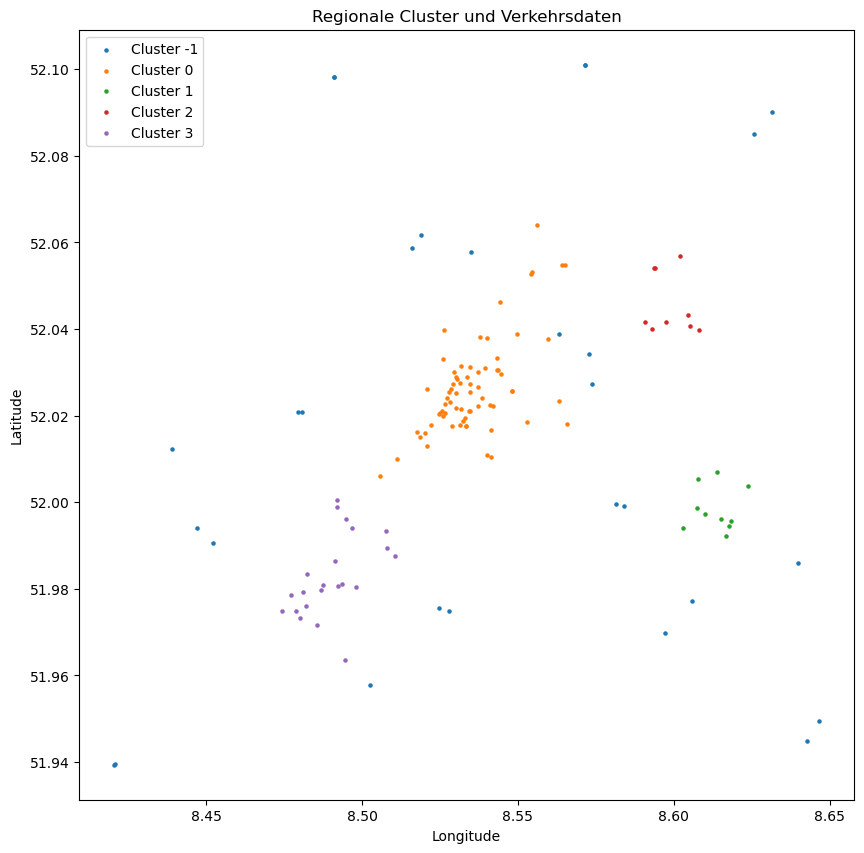

In [22]:

centroids_df['cluster'] = db.labels_
centroids_df['shape'] = traffic_data['shape'].apply(json.dumps)


fig, ax = plt.subplots(figsize=(10, 10))


for cluster_id in np.unique(db.labels_):
    cluster_data = centroids_df[centroids_df['cluster'] == cluster_id]
    ax.scatter(cluster_data['centroid_longitude'], cluster_data['centroid_latitude'], label=f'Cluster {cluster_id}', s=5)

plt.title('Regionale Cluster und Verkehrsdaten')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [23]:
centroids_df

,centroid_longitude,centroid_latitude,olr,cluster,shape
0,8.521979,52.017732,CCkBEAAlJAYP2CT9+gAJBQQBApAACgUEAYZZAP0T/ZsACQ...,0,"[{""length"": 31, ""points"": [{""lat"": 52.02013, ""..."
1,8.534673,52.027342,CCkBEAAlJAYRfST/kQAJBQQEA3AACgUEBIFvAACD/0EACQ...,0,"[{""length"": 31, ""points"": [{""lat"": 52.02887, ""..."
2,8.529081,52.027377,CCkBEAAlJAYQbyT+4QAJBQQBAhAACgUEAYRSAAEJAfsACQ...,0,"[{""length"": 24, ""points"": [{""lat"": 52.02508, ""..."
3,8.623828,52.003860,CCoBEAAmJQYjkST9bQAJBQQAAYwACgUEAKxyAPY/7VcACQ...,1,"[{""length"": 179, ""points"": [{""lat"": 52.01648, ..."
4,8.528606,52.026177,CCkBEAAlJAYQlST+5AAJBQQEA9MACgUEBIJgAAB/AQoACQ...,0,"[{""length"": 17, ""points"": [{""lat"": 52.02516, ""..."
...,...,...,...,...,...
135,8.541041,52.022406,CCkBEAAlJAYRoiT+mwAJBQQCAzkACgUEAocGAASN/xYACQ...,0,"[{""length"": 80, ""points"": [{""lat"": 52.02359, ""..."
136,8.525541,52.021173,CCkBEAAlJAYP1iT96wAJBQQBBhoACgUEAYI/AAC3AQcACQ...,0,"[{""length"": 34, ""points"": [{""lat"": 52.01982, ""..."
137,8.530254,52.028928,CCkBEAAlJAYQuST/XgAJBQQCBhAACgUEAoFmAACmAIEACQ...,0,"[{""length"": 33, ""points"": [{""lat"": 52.02778, ""..."
138,8.537072,52.022260,CCkBEAAlJAYRjyT+YAAJBQQCAzYACgUEAoMUAAI9AAAACQ...,0,"[{""length"": 110, ""points"": [{""lat"": 52.02233, ..."


In [25]:
table_name = "traffic_regional_cluster"
centroids_df.to_sql(table_name, con=engine, if_exists='append', index=False, schema='diu')

140